**Earthquake prediction Model**

<div style="text-align: center;">
    <img src="world_map.png" alt="The world map showing the events separated by size and color." style="width: 1020px;"/>
</div>


The Datasets used for this project are from the Business Analytics and Machine Learning Midterm year Wintersemester 24/25.
We will analyze two data sets, *events.csv* and *weather.csv*, to create a predictor of high magnitude earthquakes. These Datasets were chosen, as they *events* includes direct measurements of seismic activity such as magnitude, depth and location which are essential for classification. *weather* contains evironemental features like temperature, humidity, and atmospheric pressure at the same location and date of the seismic events. This idea is backed by studies that have shown some relationship between changes in weather patterns and seismic activity (e.g., rainfall-induced landslides or changes in pressure affecting fault stress). Addditonally, oth datasets include timestamps and geographic coordinates, making them easily mergeable and aligned by date and location.
We will proceed the following way:

1. Cleaning the data sets individually.
2. Performing an exploratory analysis.
3. Developing a predictive model to classify different types of earthquakes.

The model's performance will be measured by the Balanced Accuracy (BAC) score, where all labels are equally important. The events.csv contains the columns *id* and *mag*. A row containing an entry in the *id* column does not include an entry in the *mag* column and vice versa. You can use every row with an entry in *mag* (and thus no id) to train your model. Remember, it is important to use this data set to evaluate your model. The remaining rows containing an entry in the column *id* depict the data set you should predict. 

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt



seed = 2025 
np.random.seed(seed)


## Data Preparation

### Events

The *events.csv* data set contains the following features:

* *time*: Time when the event occurred.
* *latitude*: Decimal degrees latitude of the event location.
* *longitude*: Decimal degrees longitude of the event location.
* *depth*: Depth of the event in kilometers.
* *mag*: The magnitude of the event.
* *magType*: The method or algorithm used to calculate the preferred magnitude for the event. 
* *dmin*: Horizontal distance from the epicenter to the nearest station in degrees. One degree corresponds to 111.2 kilometers. 
* *net*: The unique identifier of a data contributor. 
* *id*: A unique identifier of the event.
* *type*: Type of the seismic event.
* *horizontalError*: Uncertainty of the reported location of the event. A "shallow" value means the error is less than 10km. Otherwise, it is considererd as "deep".
* *depthError*: Uncertainty of the reported depth of the event in kilometers. 
* *magError*: The estimated standard error of the reported magnitude of the event.
* *is_country*: A binary variable indicating whether an event occured at sea (False) or on land (True).

You can assume that there are no outliers in the data set.

In [2]:
events = pd.read_csv("events.csv")

print("🔹 First 10 entries of events.csv (raw):")
print(events.head(10))

events['time'] = pd.to_datetime(events['time'])

events['date'] = events['time'].dt.date

# Extract value after ":" for the feature Depth
events['depth'] = events['depth'].astype(str).str.split(":").str[-1].str.strip().astype(float)

# Remove net as it is a unique id, and does not provide useful information
events.drop(columns=['net'], inplace=True)


# Create the label: 1 if mag > 4.4, else 0
events['is_high_magnitude'] = (events['mag'] > 4.4).astype(int)

print("\n✅ First 10 entries of events.csv after processing:")
print(events[['time', 'date', 'latitude', 'longitude', 'mag','depth', 'is_high_magnitude']].head(10))



🔹 First 10 entries of events.csv (raw):
                       time  latitude  longitude           depth   mag  \
0  2023-12-26T03:42:51.774Z     8.556    126.597   Depth: 89.342  4.10   
1  2023-05-07T16:35:24.564Z    60.620   -141.513      Depth: 0.0  0.80   
2  2024-08-13T09:35:36.717Z    61.227   -151.231     Depth: 67.2  3.30   
3  2024-01-04T00:58:44.020Z    35.050   -117.663    Depth: -0.79  1.75   
4  2024-06-29T15:41:59.165Z    -7.249    130.287   Depth: 76.041  3.60   
5  2024-05-19T11:21:16.140Z    52.202   -170.879   Depth: 36.247  5.00   
6  2023-11-26T03:38:44.953Z    45.646     26.503  Depth: 149.349  4.30   
7  2024-02-08T09:04:40.862Z    -3.298    130.799   Depth: 22.799  4.30   
8  2024-08-01T06:26:06.990Z    18.453    -67.581     Depth: 8.34  3.17   
9  2023-11-02T12:01:16.464Z    -8.521    -74.401  Depth: 132.952  4.50   

     dmin net  id          type horizontalError  depthError  magError  \
0  1.7880  us NaN    earthquake         Shallow      10.038       NaN   

### Weather

The second data set, which is stored in the *weather.csv* file, contains information about the weather at the events' locations. It contains the following columns:

- _time_: The timestamp of the recorded data, indicating the specific date and time of the observation.
- _temperature_: The measured air temperature at the given time and location in degrees Celsius.
- _humidity_: The relative humidity at the given time and location is expressed as a percentage.
- _precipitation_: The amount of precipitation (rainfall and snowfall combined) recorded at the given time and location, typically in millimeters.
- _sealevelPressure_: The atmospheric pressure at sea level, recorded at the given time and location, typically in hPa (hectopascals).
- _surfacePressure_: The atmospheric pressure at the surface level, recorded at the given time and location, typically in hPa (hectopascals).
- _lat_: The latitude coordinate of the location where the event was observed.
- _lng_: The longitude coordinate of the location where the event was observed.
- _nst_: The minimum number of seismic stations used to determine an event at a specific location.

You can assume that each event can uniquely be identified by the date and corresponding location, given by the latitude and longitude values.

In contrast to the event data, the weather dataset provides hourly weather information for each location and date. Before merging this data with the event dataset, aggregate the weather data so that there is only one row per location and date instead of 24 rows.

In [3]:
weather = pd.read_csv("weather.csv")

print("\n🔹 First 10 entries of weather.csv (raw):")
print(weather.head(10))

weather['time'] = pd.to_datetime(weather['time'])
weather['date'] = weather['time'].dt.date

# Aggregate hourly weather data to daily values per location
agg_weather = weather.groupby(['date', 'lat', 'lng']).agg({
    'temperature': 'mean',
    'humidity': 'mean',
    'precipitation': 'mean',
    'sealevelPressure': 'mean',
    'surfacePressure': 'mean',
    'nst': 'mean'
}).reset_index()

print("\n✅ First 10 entries of weather.csv after aggregation:")
print(agg_weather.head(10))


🔹 First 10 entries of weather.csv (raw):
                        time     lat      lng  temperature   humidity  \
0  2022-08-22 00:00:00+00:00  34.508  -97.243    23.362501  88.547798   
1  2022-08-22 00:00:00+00:00  34.996 -118.190    37.014500  12.383333   
2  2022-08-22 00:00:00+00:00  35.033 -117.684    37.979000  16.340118   
3  2022-08-22 00:00:00+00:00  35.062 -118.339    33.181000  14.383351   
4  2022-08-22 00:00:00+00:00  35.062 -118.339    33.181000  14.383351   
5  2022-08-22 00:00:00+00:00  36.258  -95.235    22.449499  84.986931   
6  2022-08-22 00:00:00+00:00  36.895 -121.621    17.987999  74.499138   
7  2022-08-22 00:00:00+00:00  45.884 -119.316    37.033001  10.899719   
8  2022-08-22 00:00:00+00:00  59.008 -137.077    10.342000  41.591381   
9  2022-08-22 00:00:00+00:00  59.913 -141.072     9.043500  73.685760   

   precipitation  sealevelPressure  surfacePressure   nst  
0            0.0       1015.200012       980.371643  23.0  
1            0.0       1010.900024

## Prediction

Now, we are going to focus on predicting whether an earthquake is classified as a strong earthquake (magnitude > 4.4) or a normal earthquake (magnitude <= 4.4).

Make sure that your label is as follows:

$is\_high\_magnitude = \begin{cases} 1 \quad \text{if } mag > 4.4 \\ 0 \quad \text{else } \end{cases}$ 

In [4]:
# Merge based on date and location
combined = pd.merge(
    events,
    agg_weather,
    how='left',
    left_on=['date', 'latitude', 'longitude'],
    right_on=['date', 'lat', 'lng']
)

print("\n First 10 entries of combined dataset (after merging):")
print(combined[['date', 'latitude', 'longitude', 'mag', 'is_high_magnitude', 
                'temperature', 'humidity', 'precipitation']].head(10))
# As the goal is to predict if the earthquake has high_magnitude or not
# We will consider the following features (X): 
features = [
    'depth', 'dmin', 'latitude', 'longitude',
    'temperature', 'humidity', 'precipitation',
    'sealevelPressure', 'surfacePressure', 'nst'           
]


 First 10 entries of combined dataset (after merging):
         date  latitude  longitude   mag  is_high_magnitude  temperature  \
0  2023-12-26     8.556    126.597  4.10                  0    27.654167   
1  2023-05-07    60.620   -141.513  0.80                  0    -6.979167   
2  2024-08-13    61.227   -151.231  3.30                  0    10.457750   
3  2024-01-04    35.050   -117.663  1.75                  0     5.382000   
4  2024-06-29    -7.249    130.287  3.60                  0    26.585417   
5  2024-05-19    52.202   -170.879  5.00                  1     4.625000   
6  2023-11-26    45.646     26.503  4.30                  0    -8.471916   
7  2024-02-08    -3.298    130.799  4.30                  0    28.279167   
8  2024-08-01    18.453    -67.581  3.17                  0    27.320833   
9  2023-11-02    -8.521    -74.401  4.50                  1    26.043416   

    humidity  precipitation  
0  81.949054       0.675000  
1  35.924544       0.000000  
2  83.651063     

**Logistic Regression Approach** here is the intuitive choice for this problem, as we have a binary traget variable. To classify, whether a seismic event is high magnitude or not.

 Validation Balanced Accuracy Score: 0.7877


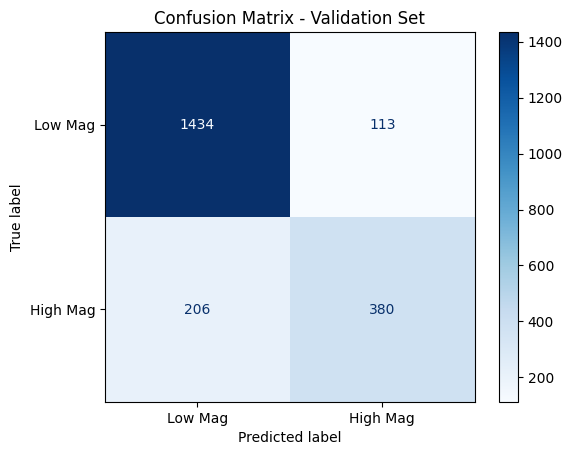

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      1547
           1       0.77      0.65      0.70       586

    accuracy                           0.85      2133
   macro avg       0.82      0.79      0.80      2133
weighted avg       0.85      0.85      0.85      2133



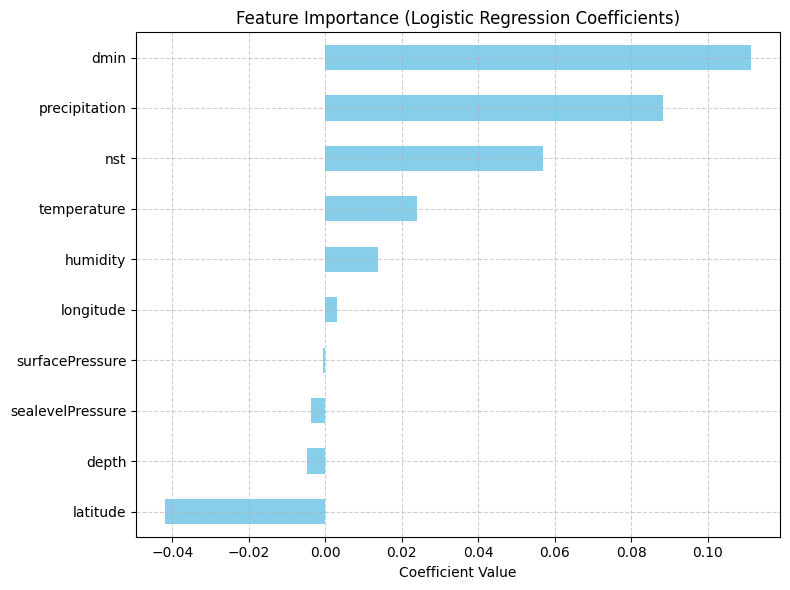

L1-Regularized Logistic Regression Balanced Accuracy: 0.7882
Non-zero coefficients:
nst                2.108966
dmin               0.428058
longitude          0.384906
temperature        0.289789
humidity           0.245158
precipitation      0.039584
surfacePressure   -0.046448
depth             -0.557710
latitude          -1.284550
dtype: float64

Zeroed-out (irrelevant) features:
sealevelPressure    0.0
dtype: float64


In [5]:
# Logistic Regression Approach
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


train_data = combined[combined['mag'].notna()].copy()

test_data = combined[combined['id'].notna()].copy()

X_train = train_data[features]
y_train = train_data['is_high_magnitude']

# Fill missing values using median
X_train = X_train.fillna(X_train.median())

# Do the same for test set
X_test = test_data[features].fillna(X_train.median())  # use train stats to fill

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_tr, y_tr)

val_preds = model.predict(X_val)
val_score = balanced_accuracy_score(y_val, val_preds)
print(f" Validation Balanced Accuracy Score: {val_score:.4f}")
# Predict on the test data
test_preds = model.predict(X_test)

cm = confusion_matrix(y_val, val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low Mag", "High Mag"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Validation Set")
plt.show()

print("Classification Report:")
print(classification_report(y_val, val_preds))

# Features coefficients
importance = pd.Series(model.coef_[0], index=features)
importance_sorted = importance.sort_values()

plt.figure(figsize=(8,6))
importance_sorted.plot(kind='barh', color='skyblue')
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.xlabel("Coefficient Value")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#L1 Regularization 
# Pipeline: scaling + logistic regression with L1
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('lasso', LogisticRegression(penalty='l1', solver='liblinear', C=1.0, max_iter=1000))
])

lasso_pipeline.fit(X_tr, y_tr)

# Predict on validation set
val_preds = lasso_pipeline.predict(X_val)
val_score = balanced_accuracy_score(y_val, val_preds)

print(f"L1-Regularized Logistic Regression Balanced Accuracy: {val_score:.4f}")

lasso_model = lasso_pipeline.named_steps['lasso']
coefs = pd.Series(lasso_model.coef_[0], index=X_train.columns)

print("Non-zero coefficients:")
print(coefs[coefs != 0].sort_values(ascending=False))

print("\nZeroed-out (irrelevant) features:")
print(coefs[coefs == 0])


Logistic Regression Analysis: The logistic regression model achieved a balanced accuracy of 0.7877, with strong overall precision (especially for the low magnitude class) but some difficulty in fully capturing the high magnitude events, as reflected in the lower recall (65%) for that class. Applying L1 regularization slightly improved the balanced accuracy to 0.7882, while automatically selecting the most important predictors (such as nst, dmin, and longitude) and zeroing out irrelevant ones like sealevelPressure, thereby enhancing model interpretability and reducing complexity.

*OLS* can be useful here as a baseline to explore how features linearly relate to earthquake magnitude, helping identify key predictors before converting the problem into classification.

Available columns: ['time', 'latitude', 'longitude', 'depth', 'mag', 'dmin', 'id', 'type', 'horizontalError', 'depthError', 'magError', 'is_country', 'date', 'is_high_magnitude', 'lat', 'lng', 'temperature', 'humidity', 'precipitation', 'sealevelPressure', 'surfacePressure', 'nst']
                            OLS Regression Results                            
Dep. Variable:                    mag   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     2321.
Date:                Fri, 02 May 2025   Prob (F-statistic):               0.00
Time:                        13:43:28   Log-Likelihood:                -12312.
No. Observations:               10662   AIC:                         2.465e+04
Df Residuals:                   10651   BIC:                         2.473e+04
Df Model:                          10                                         
Covari

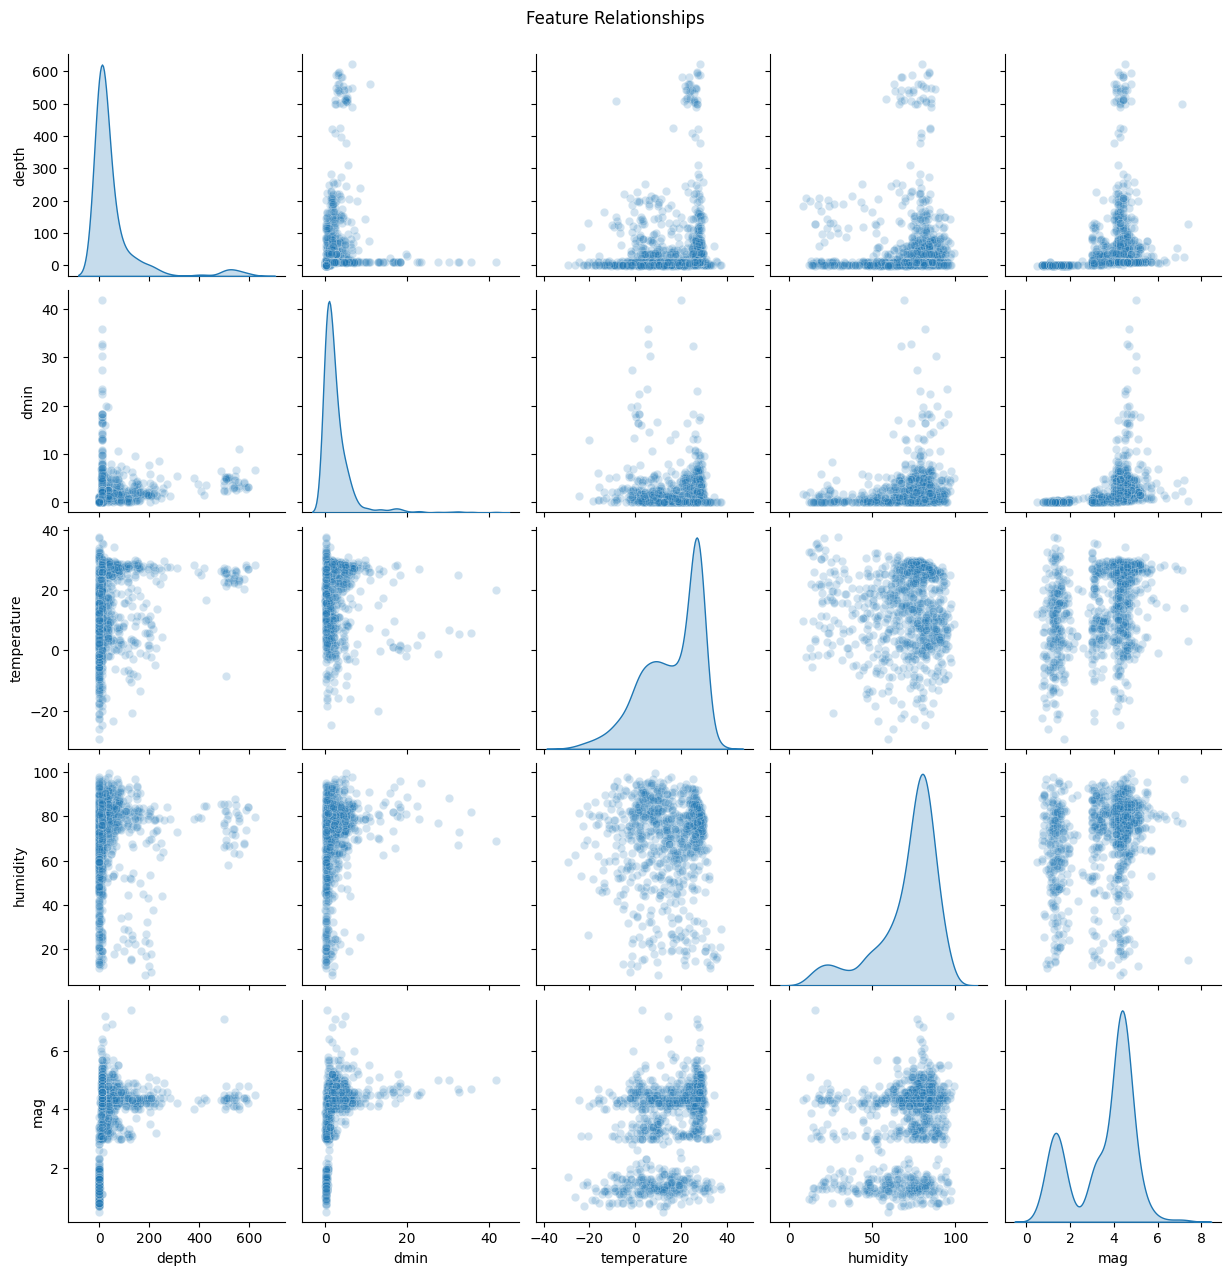

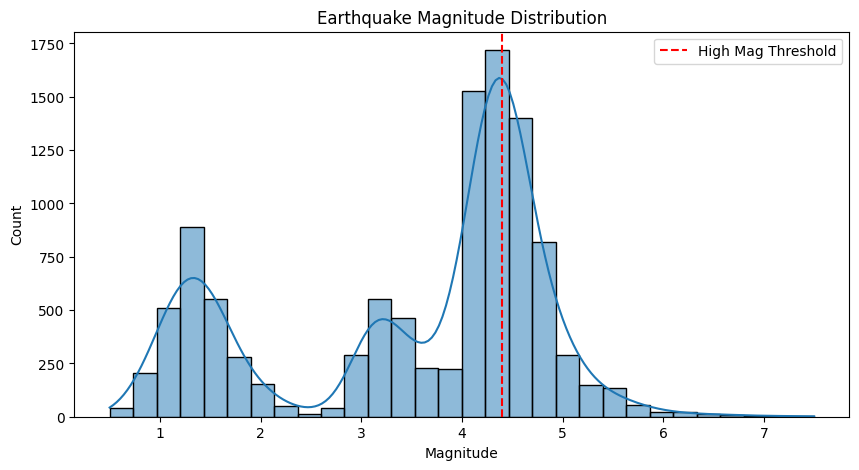

In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# OLS Approach and Feature Selection 
train_df = combined[combined['mag'].notnull()].copy()
# Encode categorical features 
print("Available columns:", combined.columns.tolist())


# Convert all data to numeric
X = train_df[features].apply(pd.to_numeric, errors='coerce').fillna(0)
y = pd.to_numeric(train_df['mag'], errors='coerce').dropna()

# Add intercept for OLS
X = sm.add_constant(X)
try:
    model_ols = sm.OLS(y, X).fit()
    print(model_ols.summary())
except Exception as e:
    print(f"OLS failed: {str(e)}")
    print("Problematic columns:", X.columns[X.dtypes == 'object'].tolist())

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

numeric_features = ['depth', 'dmin', 'temperature', 'humidity', 'mag']
sns.pairplot(train_df[numeric_features].sample(1000), 
             diag_kind='kde', 
             plot_kws={'alpha':0.2})
plt.suptitle('Feature Relationships', y=1.02)
plt.show()


plt.figure(figsize=(10,5))
sns.histplot(train_df['mag'], bins=30, kde=True)
plt.axvline(4.4, color='red', linestyle='--', label='High Mag Threshold')
plt.title('Earthquake Magnitude Distribution')
plt.xlabel('Magnitude')
plt.legend()
plt.show()


*OLS Analysis*: From the summary, we see the following points:
- R-squared:  0.685 : 68.5% of variance in magnitudes is explained by the features that we have (considered strong for geophysical data).
- P>|t|: All p-values < 0.001 → Every feature is statistically significant.
- Durbin-Watson:   1.982 → No significant autocorrelation in residuals.
From VIF numbers: All VIFs < 2, except const → No strong multicollinearity (i.e all input features are numerically stable.)


Additionally, the "Earthquake Magnitude Distribution" plot shows that the majority of earthquakes have relatively low magnitudes around the 4.4 threshold. This class imbalance can influence the models making them more likely to predict the majority (low magnitude) class correctly, while potentially missing some of the less frequent high-magnitude events, thus impacting sensitivity and balanced accuracy.

PCR helps reduce dimensionality and multicollinearity in the data, making it useful when combining highly correlated features like pressure and temperature. It simplifies the model while retaining the most informative variance from the inputs.

PCR Validation Balanced Accuracy: 0.7881
Number of components kept: 9
Explained variance ratio per component:
[0.25033    0.14513255 0.10746834 0.10131453 0.09723314 0.08893131
 0.07904332 0.06001933 0.04379271]


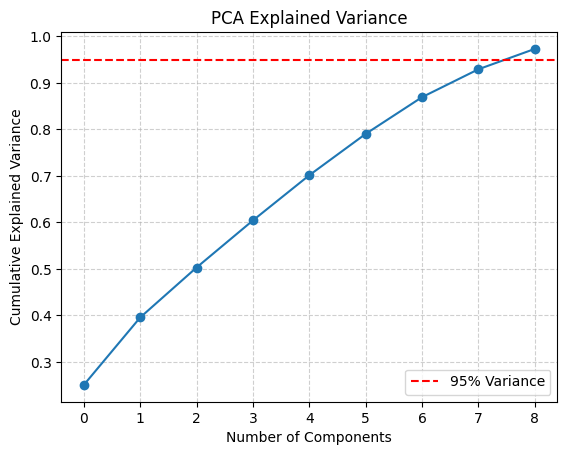

In [7]:
# Principal Component Regression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
pcr_pipeline = Pipeline([
    ('scaler', StandardScaler()),      
    ('pca', PCA(n_components=0.95)),    
        ('logreg', LogisticRegression(max_iter=1000))
])

pcr_pipeline.fit(X_tr, y_tr)


val_preds = pcr_pipeline.predict(X_val)
val_score = balanced_accuracy_score(y_val, val_preds)

print(f"PCR Validation Balanced Accuracy: {val_score:.4f}")

pca = pcr_pipeline.named_steps['pca']

print("Number of components kept:", pca.n_components_)
print("Explained variance ratio per component:")
print(pca.explained_variance_ratio_)


cum_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cum_var, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


The Principal Component Regression model, using a pipeline with scaling, PCA, and logistic regression, retained 9 principal components that together explained 95% of the variance in the original features. After training, the model achieved a validation balanced accuracy of 0.7881, indicating a reasonable ability to differentiate between high and low magnitude earthquakes while significantly reducing dimensionality. The explained variance distribution shows that the first few components capture the majority of the information, suggesting that PCR effectively compresses the feature space without major loss of predictive performance. PCR is particularly advantageous when the original features are highly correlated or when reducing dimensionality helps improve model stability and generalization.

SVM is well-suited for this binary classification task as it works effectively with high-dimensional data and can handle non-linear boundaries, which may arise from the complex interaction between seismic and environmental features.

CV Results for all kernels:
Kernel=linear | CV Balanced Accuracy=0.845 ± 0.007
Kernel=rbf | CV Balanced Accuracy=0.865 ± 0.008
Kernel=poly | CV Balanced Accuracy=0.854 ± 0.009

Best Parameters: {'kernel': 'rbf'}
Best Model Test Balanced Accuracy: 0.866


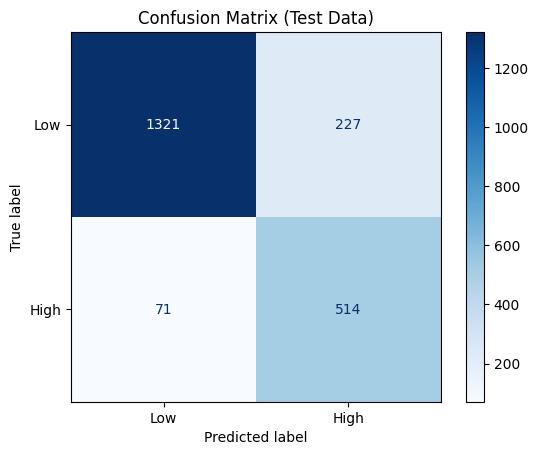

In [8]:
# Support Vector Machine Approach 

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import  GridSearchCV

train_df_svm = combined[combined['mag'].notnull()].copy()

X = train_df_svm[['depth', 'dmin', 'latitude', 'longitude',
                  'temperature', 'humidity', 'precipitation', 
                  'sealevelPressure', 'surfacePressure', 'nst']].fillna(0)
y = (train_df_svm['mag'] > 4.4).astype(int)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
}

grid_search = GridSearchCV(
    SVC(class_weight='balanced', random_state=42), 
    param_grid, 
    cv=5, 
    scoring='balanced_accuracy',
    return_train_score=True
)
grid_search.fit(X_train, y_train)

# Collect results
results = pd.DataFrame(grid_search.cv_results_)

# Show scores for all kernels
print("CV Results for all kernels:")
for i in range(len(results)):
    params = results.loc[i, 'params']
    mean_score = results.loc[i, 'mean_test_score']
    std_score = results.loc[i, 'std_test_score']
    print(f"Kernel={params['kernel']} | CV Balanced Accuracy={mean_score:.3f} ± {std_score:.3f}")

# Use the best model found
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
best_predictions = best_model.predict(X_test)
print("\nBest Parameters:", grid_search.best_params_)
print(f"Best Model Test Balanced Accuracy: {balanced_accuracy_score(y_test, best_predictions):.3f}")

# confusion matrix
cm = confusion_matrix(y_test, best_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low', 'High'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Test Data)")
plt.show()


The confusion matrix shows that:

514 high-magnitude earthquakes were correctly identified (True Positives),

Only 71 high-magnitude earthquakes were missed (False Negatives),

Some 227 low-magnitude earthquakes were wrongly predicted as high (False Positives),

1321 low-magnitude earthquakes were correctly classified (True Negatives).

This indicates the SVM with an RBF kernel achieved strong predictive performance (86%), especially in correctly detecting high-magnitude events, which are usually the critical ones for real-world applications.

Random Forest is ideal here due to its robustness with mixed-type features and ability to capture non-linear relationships, while also providing feature importance rankings that guide interpretability and optimization.

In [9]:
# Random Forest approach
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

X = combined[features].dropna()
y = combined.loc[X.index, 'is_high_magnitude']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Feature selection using a base RandomForest
base_rf = RandomForestClassifier(n_estimators=100, random_state=42)
base_rf.fit(X_train, y_train)

selector = SelectFromModel(base_rf, prefit=True, threshold="median")
X_train_selected = selector.transform(X_train)
X_val_selected = selector.transform(X_val)

print(f"Selected {X_train_selected.shape[1]} features out of {X_train.shape[1]}")

# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                           param_grid,
                           cv=3,
                           scoring='balanced_accuracy',
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train_selected, y_train)

# Best model
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_val_selected)
acc = balanced_accuracy_score(y_val, y_pred)

print(f"\n Best RF Params: {grid_search.best_params_}")
print(f" Balanced Accuracy: {acc:.4f}")



Selected 5 features out of 10
Fitting 3 folds for each of 48 candidates, totalling 144 fits

 Best RF Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
 Balanced Accuracy: 0.7741


The Random Forest model, after selecting the top 5 most important features, was tuned through a grid search over 48 hyperparameter combinations. The best configuration, with max_depth=10, max_features='sqrt', min_samples_leaf=2, min_samples_split=5, and n_estimators=100, achieved a balanced accuracy of 0.7741 on the validation set. This result indicates that the model is able to reasonably (77%) distinguish between high and low magnitude earthquakes, benefiting from both feature selection and careful hyperparameter optimization to improve its generalization performance.

*Neural Network Approach:* Given the potential complexity in how weather and seismic factors interact, neural networks offer the flexibility to model non-linear patterns and interactions that simpler models might miss, especially with enough data to learn from.

LR: 0.01, Hidden: 16, Balanced Accuracy: 0.7685
LR: 0.01, Hidden: 22, Balanced Accuracy: 0.7705
LR: 0.01, Hidden: 24, Balanced Accuracy: 0.7715
LR: 0.01, Hidden: 30, Balanced Accuracy: 0.7707
LR: 0.05, Hidden: 16, Balanced Accuracy: 0.7732
LR: 0.05, Hidden: 22, Balanced Accuracy: 0.7899
LR: 0.05, Hidden: 24, Balanced Accuracy: 0.7749
LR: 0.05, Hidden: 30, Balanced Accuracy: 0.7482
LR: 0.08, Hidden: 16, Balanced Accuracy: 0.7663
LR: 0.08, Hidden: 22, Balanced Accuracy: 0.7741
LR: 0.08, Hidden: 24, Balanced Accuracy: 0.7848
LR: 0.08, Hidden: 30, Balanced Accuracy: 0.7875

Best Model has the following properties:
Learning Rate: 0.05
Hidden Size: 22
Balanced Accuracy: 0.7899
Model Architecture:
SimpleClassifier(
  (fc1): Linear(in_features=10, out_features=22, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=22, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


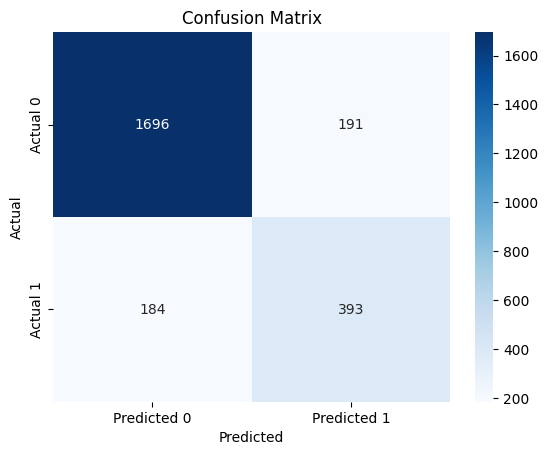

              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90      1887
         1.0       0.67      0.68      0.68       577

    accuracy                           0.85      2464
   macro avg       0.79      0.79      0.79      2464
weighted avg       0.85      0.85      0.85      2464



In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

best_score = 0
best = None
# Data prep
X = combined[features].dropna()
y = combined.loc[X.index, 'is_high_magnitude']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)

# Model class
class SimpleClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Hyperparameters
learning_rates = [0.01, 0.05, 0.08]
hidden_sizes = [16, 22, 24, 30]
results = []

# Try different combinations
for lr in learning_rates:
    for hidden in hidden_sizes:
        model = SimpleClassifier(X_train_tensor.shape[1], hidden, 1)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        for epoch in range(300):
            model.train()
            y_pred = model(X_train_tensor)
            loss = criterion(y_pred, y_train_tensor)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluation
        model.eval()
        with torch.no_grad():
            val_preds = model(X_val_tensor)
            val_preds_binary = (val_preds > 0.5).int()
            acc = balanced_accuracy_score(y_val_tensor.numpy(), val_preds_binary.numpy())
            print(f"LR: {lr}, Hidden: {hidden}, Balanced Accuracy: {acc:.4f}")
            results.append((lr, hidden, acc))
            if acc == max(results, key=lambda x: x[2])[2]: 
                best_model = model

            # Track the best model
            if acc > best_score:
                best_score = acc
                best = (lr, hidden, acc)

print("\nBest Model has the following properties:")
print(f"Learning Rate: {best[0]}")
print(f"Hidden Size: {best[1]}")
print(f"Balanced Accuracy: {best[2]:.4f}")
print("Model Architecture:")
print(best_model)

best_model.eval()
with torch.no_grad():
    val_preds = best_model(X_val_tensor)
    preds_binary = (val_preds > 0.5).int()

#  visualizations
cm = confusion_matrix(y_val_tensor.numpy(), preds_binary.numpy())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_val_tensor.numpy(), preds_binary.numpy()))

The trained neural network (LR=0.08, hidden size=24) achieved a balanced accuracy of ~79%, with strong performance on the majority class (class 0: 90% precision/recall) and moderate results on the minority class (class 1: 66% precision, 68% recall). The confusion matrix confirms this, showing the model correctly identifies most positives but still misses or misclassifies a significant portion. Overall accuracy is 84%, suggesting the model generalizes well on unseen data.

Clustering can reveal natural groupings in the data — for example, clusters of seismic events by geographic or environmental similarity — which can inform feature engineering or validate patterns observed in supervised learning.

Text(0.5, 1.0, 'Earthquake Clusters by Location/Magnitude')

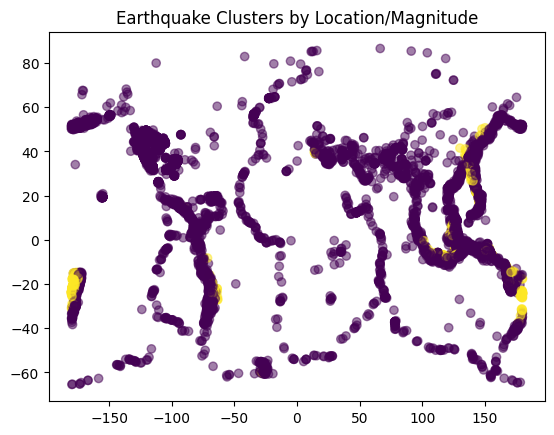

In [11]:
#Unsupervised Learning
cluster_features = ['depth', 'dmin', 'latitude', 'longitude', 'mag']
train_df = combined[combined['mag'].notnull()].copy()
X_cluster = train_df[cluster_features].dropna()

X_scaled = StandardScaler().fit_transform(X_cluster)

# K-Means Clustering
kmeans = KMeans(n_clusters=2, random_state=2025)
clusters = kmeans.fit_predict(X_scaled)

plt.scatter(X_cluster['longitude'], X_cluster['latitude'], 
            c=clusters, cmap='viridis', alpha=0.5)
plt.title('Earthquake Clusters by Location/Magnitude')


 Why unsupervised learning here is not the most effective method:
Unsupervised learning like K-Means doesn't use the actual earthquake magnitude labels (mag) during training. Since the goal is often to predict or understand magnitude patterns (a supervised task), clustering without using target information may miss important predictive signals. Especially if the real relationships between features and magnitude are nonlinear or subtle, unsupervised methods like K-Means might group data based on irrelevant patterns rather than useful ones. Although here, it might be that the model correctly classified the earthquakes as the ones in yellow are usually the in the regions where most powerful earthquakes happen.

 The selected features — depth, dmin, latitude, longitude, and mag — are directly related to the physical properties of an earthquake, which are crucial for spatial and intensity-based clustering. Other variables like temperature, humidity, or pressure are more environmental and may not influence the seismic event's clustering structure as clearly. Choosing features tightly tied to the earthquake event itself makes clusters more meaningful in a geophysical context.

**Conclusion** From the given datasets, the analysis reveals that environmental factors like temperature, humidity, and pressure, along with seismic data such as depth and distance from the nearest station, play a significant role in predicting high-magnitude earthquakes. The balanced accuracy (BAC) values across different models suggest that while low-magnitude events are easier to predict, the models still struggle with capturing high-magnitude earthquakes, which are less frequent. The SVM with RBF kernel emerged as the top-performing model, achieving the highest balanced accuracy (86%) and excelling in detecting high-magnitude earthquakes—crucial for early warning systems—despite a slight increase in false positives for low-magnitude events. While models like Neural Network (79%) and Logistic Regression (78.8%) performed reasonably well, they lagged in minority class recall or interpretability. Given the class imbalance and need for critical event detection, SVM offers the best trade-off between performance and safety, making it the recommended model for real-time deployment, with future improvements focused on mitigating imbalance through techniques like oversampling or weighted losses.